In [7]:
import json
import itertools
from basics import *
from plotting import *
from matplotlib import cm
from ase import Atoms
from scipy import stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from plotting import savefig

plt.style.use("paper")

## Visualizing the Monte Carlo approach

In [8]:
facets = [100, 111, 211, 331, 410, 711]
nads = np.arange(2, 19)
num_sites = {100: 16, 111: 16, 211: 24, 331: 24, 410: 24, 711: 16}

In [9]:
df = pd.read_csv("../data/mcmc/energies.csv.gz", compression="gzip", index_col=0)

In [10]:
results = pd.read_json("../data/mcmc/mcmc_results.json")

In [11]:
results

,id,facet,replica,move,nads,binding_unrelax,binding_unrelax_site,atoms
0,32300,410,887,86,11,-1.465769,-0.133252,"{'numbers': [29, 29, 29, 29, 29, 29, 29, 29, 2..."
1,32301,410,563,164,10,-2.140880,-0.214088,"{'numbers': [29, 29, 29, 29, 29, 29, 29, 29, 2..."
2,32302,410,999,7,5,-2.288657,-0.457731,"{'numbers': [29, 29, 29, 29, 29, 29, 29, 29, 2..."
3,32303,331,58,176,14,10.962752,0.783054,"{'numbers': [29, 29, 29, 29, 29, 29, 29, 29, 2..."
4,32304,410,985,147,4,-1.845706,-0.461426,"{'numbers': [29, 29, 29, 29, 29, 29, 29, 29, 2..."
...,...,...,...,...,...,...,...,...
1776,33625,711,690,146,14,18.761080,1.340077,"{'numbers': [29, 29, 29, 29, 29, 29, 29, 29, 2..."
1777,33626,331,129,81,8,-0.988787,-0.123598,"{'numbers': [29, 29, 29, 29, 29, 29, 29, 29, 2..."
1778,33627,410,174,35,6,-2.536058,-0.422676,"{'numbers': [29, 29, 29, 29, 29, 29, 29, 29, 2..."
1779,33628,331,451,174,7,-0.991880,-0.141697,"{'numbers': [29, 29, 29, 29, 29, 29, 29, 29, 2..."


In [12]:
selected = [
    (row["facet"], row["nads"], row["replica"], row["move"])
    for _, row in results.iterrows()
]

In [13]:
idf = df.set_index(["facet", "n", "replica", "move"])
isel = [
    idf.loc[idx]
    for idx in selected
]

In [14]:
sel = pd.DataFrame(isel)
sel = sel.reset_index()
sel.columns = ["facet", "nads", "replica", "move", "energy"]

sel["crystal_id"] = results["id"]
sel["dft_energy_site"] = results["binding_unrelax_site"]
sel["ml_energy_site"] = sel["energy"] / sel["nads"]
sel = sel.drop("energy", axis=1)
sel = sel.set_index("crystal_id").reset_index()

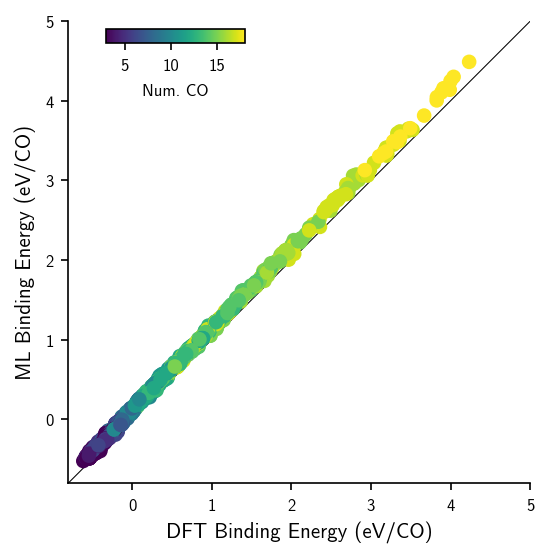

In [15]:
fig, ax = plt.subplots(figsize=(4, 4))

sc = ax.scatter(
    sel["dft_energy_site"],
    sel["ml_energy_site"],
    c=sel["nads"],
)
lims = (-0.8, 5.0)
ax.plot(lims, lims, "k-", linewidth=0.5, zorder=-1)
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_xlabel("DFT Binding Energy (eV/CO)")
ax.set_ylabel("ML Binding Energy (eV/CO)")
ax.set_aspect("equal")

cax = inset_axes(ax, width="30%", height="3%", bbox_to_anchor=(-0.6, 0, 1, 1), bbox_transform=ax.transAxes)
cbar = fig.colorbar(sc, cax=cax, orientation="horizontal")
cbar.set_label("Num. CO", loc="center", fontsize=8)

savefig(fig, "04-sampling-errors.pdf")
plt.show()

## Per-facet, per-coverage error

In [16]:
sel["sqerror"] = (sel["ml_energy_site"] - sel["dft_energy_site"]) ** 2

In [17]:
np.sqrt(sel["sqerror"].mean())

0.1253403429595343

In [18]:
rmse = (
    np.sqrt(sel.groupby(["facet", "nads"])["sqerror"].mean())
    .reset_index()
    .pivot(index="nads", columns="facet", values="sqerror")
)

In [19]:
rmse

facet,100,111,211,331,410,711
nads,,,,,,
3,0.079897,0.105265,0.072608,0.067390,0.073072,0.107276
4,0.065832,0.106985,0.067404,0.075658,0.087796,0.099031
5,0.071221,0.112475,0.070663,0.081241,0.098531,0.111100
6,0.078298,0.131825,0.081906,0.080019,0.098075,0.105694
7,0.081077,0.129807,0.091780,0.084140,0.103175,0.123994
8,0.088021,0.139245,0.100627,0.104080,0.105388,0.130357
9,0.105522,0.149669,0.097643,0.107890,0.096975,0.136341
10,0.123683,0.157878,0.121454,0.107737,0.106171,0.146740
11,0.137597,0.153711,0.124168,0.111618,0.114699,0.165094


## Coverage binding curves

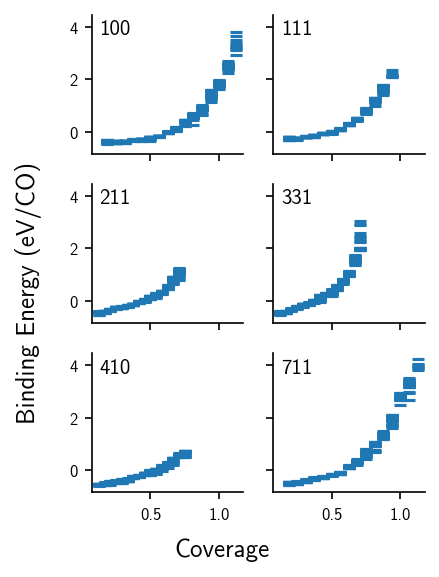

In [20]:
fig, axs = plt.subplots(3, 2, figsize=(3, 4), sharex=True, sharey=True)

for (facet, grp), ax in zip(sel.groupby("facet"), axs.reshape(-1)):
    energy = grp["dft_energy_site"]
    cov = grp["nads"] / num_sites[facet]
    
#     ax.scatter(grp["nads"], energy, marker="_")
    ax.scatter(cov, energy, marker="_")
    ax.annotate(facet, (0.05, 0.97), xycoords='axes fraction', va="top")
    
fig.supylabel("Binding Energy (eV/CO)", x=0.04)
fig.supxlabel("Coverage", y=0.05)
fig.tight_layout()

savefig(fig, "04-coverage-facets.pdf")
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x1381a79d0> (for post_execute):


KeyboardInterrupt: 

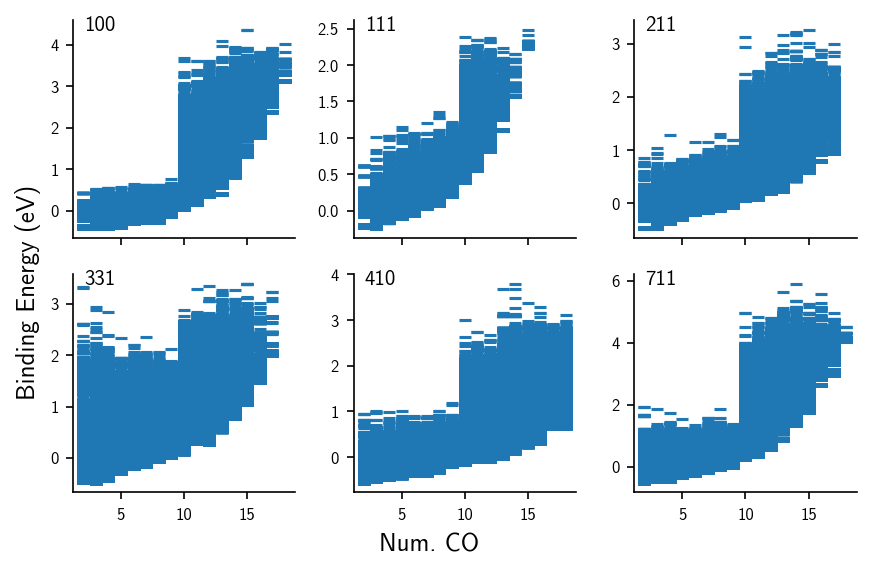

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(6, 4), sharex=True)

for (facet, grp), ax in zip(df.groupby("facet"), axs.reshape(-1)):    
    ax.scatter(grp["n"], grp["energy"] / grp["n"], marker="_")
    ax.annotate(facet, (0.05, 0.95), xycoords='axes fraction')
    
fig.supylabel("Binding Energy (eV)", x=0.04)
fig.supxlabel("Num. CO", y=0.06)
fig.tight_layout()
savefig(fig, "04-coverage-ml.pdf")
plt.show()

In [59]:
x = sel["dft_energy_site"].values
y = sel["ml_energy_site"].values
err = x - y
rmse = np.sqrt((err ** 2).mean())

In [60]:
rmse

0.12534034296060265

In [84]:
len(sel)

1781

In [63]:
df

,move,replica,energy,facet,n
0,0,0,-0.026355,100,2
1,0,1,-0.354427,100,2
2,0,2,-0.094362,100,2
3,0,3,0.150745,100,2
4,0,4,-0.119381,100,2
...,...,...,...,...,...
176,176,0,72.814459,711,18
177,177,0,72.814459,711,18
178,178,0,72.814459,711,18
179,179,0,72.814459,711,18


## Energy distribution